In [ ]:
#installing kaggle 
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#making a directory
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/kaggle.json

In [ ]:
#Downloading Dataset 2
! kaggle datasets download ayuraj/asl-dataset

 72% 41.0M/56.9M [00:00<00:00, 116MB/s] 
100% 56.9M/56.9M [00:00<00:00, 110MB/s]


In [ ]:
# Unziping dataset 2
! unzip asl-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_dataset/0/hand2_0_dif_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_dif_seg_5_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_left_seg_5_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_1_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_2_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_3_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_4_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0_right_seg_5_cropped.jpeg  
  inflating: asl_dataset/0/hand2_0

In [ ]:
# Importing necessary libraries
import os
from torch.utils.data import dataloader
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import statistics
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score,precision_score,recall_score

In [ ]:
# list the classes present in the dataset
os.listdir('/content/asl_dataset/asl_dataset')

['0',
 'g',
 'q',
 'y',
 'x',
 '6',
 'w',
 'b',
 'i',
 'd',
 '4',
 'e',
 'l',
 't',
 'h',
 'z',
 'm',
 'k',
 '5',
 's',
 '3',
 'f',
 'n',
 'o',
 'u',
 '1',
 'c',
 'r',
 'j',
 '9',
 '2',
 '7',
 'a',
 'v',
 '8',
 'p']

In [ ]:
# getting normalization values for the dataset

dataset_2_path = '/content/asl_dataset/asl_dataset'

def get_dataset_for_normalization_values(data_path):
  dataset_training_transforms = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor()
  ])
  train_dataset = torchvision.datasets.ImageFolder(root=data_path, transform= dataset_training_transforms)
  dataset = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle = False)
  return dataset

dataset_2 = get_dataset_for_normalization_values(dataset_2_path)

In [ ]:
# function to calculate mean and standard deviation of the dataset inorder to feed it for the transformations during preprcoessing.

def get_mean_and_std(loader):
  mean = 0
  std = 0
  total_image_count = 0
  for images, _ in loader:
    image_count_in_a_batch = images.size(0)
    images = images.view(image_count_in_a_batch,images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_image_count += image_count_in_a_batch
    
  mean /= total_image_count
  std /= total_image_count

  return mean,std

In [ ]:
mean_2, std_2 = get_mean_and_std(dataset_2)

In [ ]:
# loading/preparing the dataset by applying some preprocessing and augmentation techniques.

def load_dataset(path, test_split, val_split, batch_size, input_size, mean_val, std_dev, len_size_flag):

    transform_dict = {'src' : transforms.Compose(
        [transforms.Resize(224),
         transforms.RandomHorizontalFlip(p=.25),
         transforms.RandomRotation(degrees=15),
         transforms.ToTensor(),
         transforms.Normalize(mean = mean_val, std = std_dev)])}
    
    data = datasets.ImageFolder(root = path, transform= transform_dict['src'])
    train_size = int(len(data)*(1-(test_split + val_split)))
    test_size = int(len(data)*test_split) 
    val_size = int(len(data)*val_split)

    print(data)
    print("SPLIT COUNTS", train_size,test_size,val_size)
    # logically the data was not fitting into the total logic of split so had to make the change, because of even and odd number of files.
    if len_size_flag:
      val_size=val_size+1
  
    
    train, test, val = torch.utils.data.random_split(data,[train_size, test_size, val_size])
    data_loader_train = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=False, num_workers = 0)
    data_loader_test = torch.utils.data.DataLoader(test, batch_size= batch_size, shuffle=True, drop_last=False, num_workers = 0)
    data_loader_val = torch.utils.data.DataLoader(val, batch_size= batch_size, shuffle=True, drop_last=False, num_workers = 0)
  
    return data_loader_train, data_loader_test, data_loader_val

In [ ]:
# splitting the dataset into train, test and validation splits.
training_2, testing_2, validation_2 = load_dataset(path=dataset_2_path, test_split=0.3, val_split=0.1, batch_size=32, input_size=(224,224), mean_val=mean_2, std_dev=std_2, len_size_flag=True)

Dataset ImageFolder
    Number of datapoints: 2515
    Root location: /content/asl_dataset/asl_dataset
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.25)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=tensor([0.2228, 0.1538, 0.1384]), std=tensor([0.2960, 0.2161, 0.2039]))
           )
SPLIT COUNTS 1509 754 251


In [ ]:
# function to plot the images present in the dataset.

def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = dataiter.next()
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

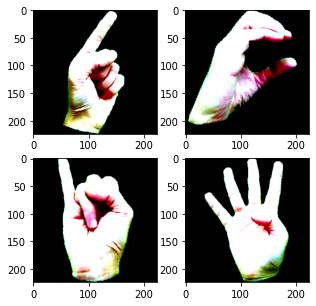

In [ ]:
# plotting the images
plot_data_loader(training_2, (2,2))

In [ ]:
# function to train the dataset as well as testing on the validation set.

def train(num_epochs, model, device, train_loader, val_loader, criterion, optimizer, t_loss, t_acc, v_loss, v_acc):

    total_steps = len(train_loader)
    print('Training starts...........')
    for epoch in range(num_epochs):
        epo_loss = []
        epo_acc = []
        epo_val_loss = []
        epo_val_acc = []
        print('')
        print('Epoch {}'.format(epoch+1))
        for i, data in enumerate(train_loader):
            model.train()
            images, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output,labels)
            loss.backward()
            optimizer.step()
            total = labels.size(0)
            _,predicted = torch.max(output.data, 1)
            correct = (predicted == labels).sum().item()
            accuracy = (correct/total)*100


            correct_val = 0
            total_val = 0
            for data in val_loader:
                model.eval()
                with torch.no_grad():
                  images_val, labels_val = data[0].to(device), data[1].to(device)
                  outputs_val = model(images_val)
                  val_loss = criterion(outputs_val, labels_val)
                  _,predicted_val = torch.max(outputs_val.data, 1)
                  total_val += labels_val.size(0)
                  correct_val += (predicted_val == labels_val).sum().item()
                  val_accuracy = (correct_val/total_val)*100

            if (i + 1) % 48 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Training_loss: {:.4f}, Training_accuracy: {:.2f}%, Validation_loss: {:.4f}, Validation Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(), accuracy, val_loss.item(), val_accuracy))
                epo_loss.append(loss.item())
                epo_acc.append(accuracy)
                epo_val_loss.append(val_loss.item())
                epo_val_acc.append(val_accuracy)

        t_loss.append(statistics.mean(epo_loss))
        t_acc.append(statistics.mean(epo_acc))
        v_loss.append(statistics.mean(epo_val_loss))
        v_acc.append(statistics.mean(epo_val_acc))

    return model



In [ ]:
# function to test the dataset on the test set.

def test(model, device, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0 
        test_loss = 0
        y_pred = []
        y_true = [] 
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item() 
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            test_loss /= len(test_loader)
            y_pred.extend(predicted.data.cpu().numpy()) #Save Predictions
            y_true.extend(labels.data.cpu().numpy()) # Save Truth

        print('Test Accuracy of the model on the {} test images: {} having an average test loss: {:.4f}'
            .format(total, (correct / total) * 100, test_loss))
    
    return y_pred, y_true

In [ ]:
# function to make an evaluation metrics i.e. confusion matrix

def make_confusion_matrix(y_pred,y_true):
    classes = ['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u',
           'v','w','x','y','z']
    n_classes = len(classes)
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * n_classes, index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (30,15))
    sns.heatmap(df_cm, annot=True)

# **Mobile Net**

In [ ]:
# defining the mobilenet model.
mobilenet_model = models.mobilenet_v2(pretrained=False)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# setting the basic hyperparameters like learning rate, optimizer, loss function and number of epochs used for training the model.
lr = 0.001
optimizer = torch.optim.Adam(mobilenet_model.parameters(), lr = lr)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 30

In [ ]:
# checking to see if GPU is availabe and hence putting the model on GPU or "cuda", otherwise "cpu".
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
mobilenet_model.to(device) 

Device: cuda:0


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# defining empty list for training and validation loss and accuracies.
mnet_training_loss = []
mnet_training_accuracies = []
mnet_val_loss = []
mnet_val_accuracies = []

In [ ]:
# training the mobilenet model on the given dataset.
start = time.time()
mobilenet = train(num_epochs, mobilenet_model, device, training_2, validation_2, criterion, optimizer, mnet_training_loss,
                  mnet_training_accuracies,mnet_val_loss, mnet_val_accuracies)
end = time.time()
time_taken = end-start
print('Time Taken by MobileNet:', time_taken)

Training starts...........

Epoch 1
Epoch [1/30], Step [48/48], Training_loss: 3.0997, Training_accuracy: 0.00%, Validation_loss: 4.0419, Validation Accuracy: 3.17%

Epoch 2
Epoch [2/30], Step [48/48], Training_loss: 2.0453, Training_accuracy: 20.00%, Validation_loss: 4.0372, Validation Accuracy: 9.92%

Epoch 3
Epoch [3/30], Step [48/48], Training_loss: 1.6386, Training_accuracy: 40.00%, Validation_loss: 2.2004, Validation Accuracy: 38.10%

Epoch 4
Epoch [4/30], Step [48/48], Training_loss: 1.1168, Training_accuracy: 60.00%, Validation_loss: 1.5839, Validation Accuracy: 43.65%

Epoch 5
Epoch [5/30], Step [48/48], Training_loss: 0.9316, Training_accuracy: 80.00%, Validation_loss: 1.2206, Validation Accuracy: 56.75%

Epoch 6
Epoch [6/30], Step [48/48], Training_loss: 1.8307, Training_accuracy: 20.00%, Validation_loss: 0.6151, Validation Accuracy: 64.29%

Epoch 7
Epoch [7/30], Step [48/48], Training_loss: 1.8231, Training_accuracy: 40.00%, Validation_loss: 1.0940, Validation Accuracy: 69.

In [ ]:
# saving the model weights and accuracies for future reference.
torch.save(mobilenet, f'mnet_{lr}.pt')
np.savez(f'mnet_dataset2_{lr}_training_loss.npz', mnet_training_loss)
np.savez(f'mnet_dataset2_{lr}_training_accuracies.npz', mnet_training_accuracies)
np.savez(f'mnet_dataset2_{lr}_val_loss.npz', mnet_val_loss)
np.savez(f'mnet_dataset2_{lr}_val_accuracies.npz', mnet_val_accuracies)

In [ ]:
# testing the dataset on the test set and returning predicted and truth values.
mnet_y_pred, mnet_y_true = test(mobilenet_model, device, testing_2)

Test Accuracy of the model on the 754 test images: 94.03183023872678 having an average test loss: 0.0022


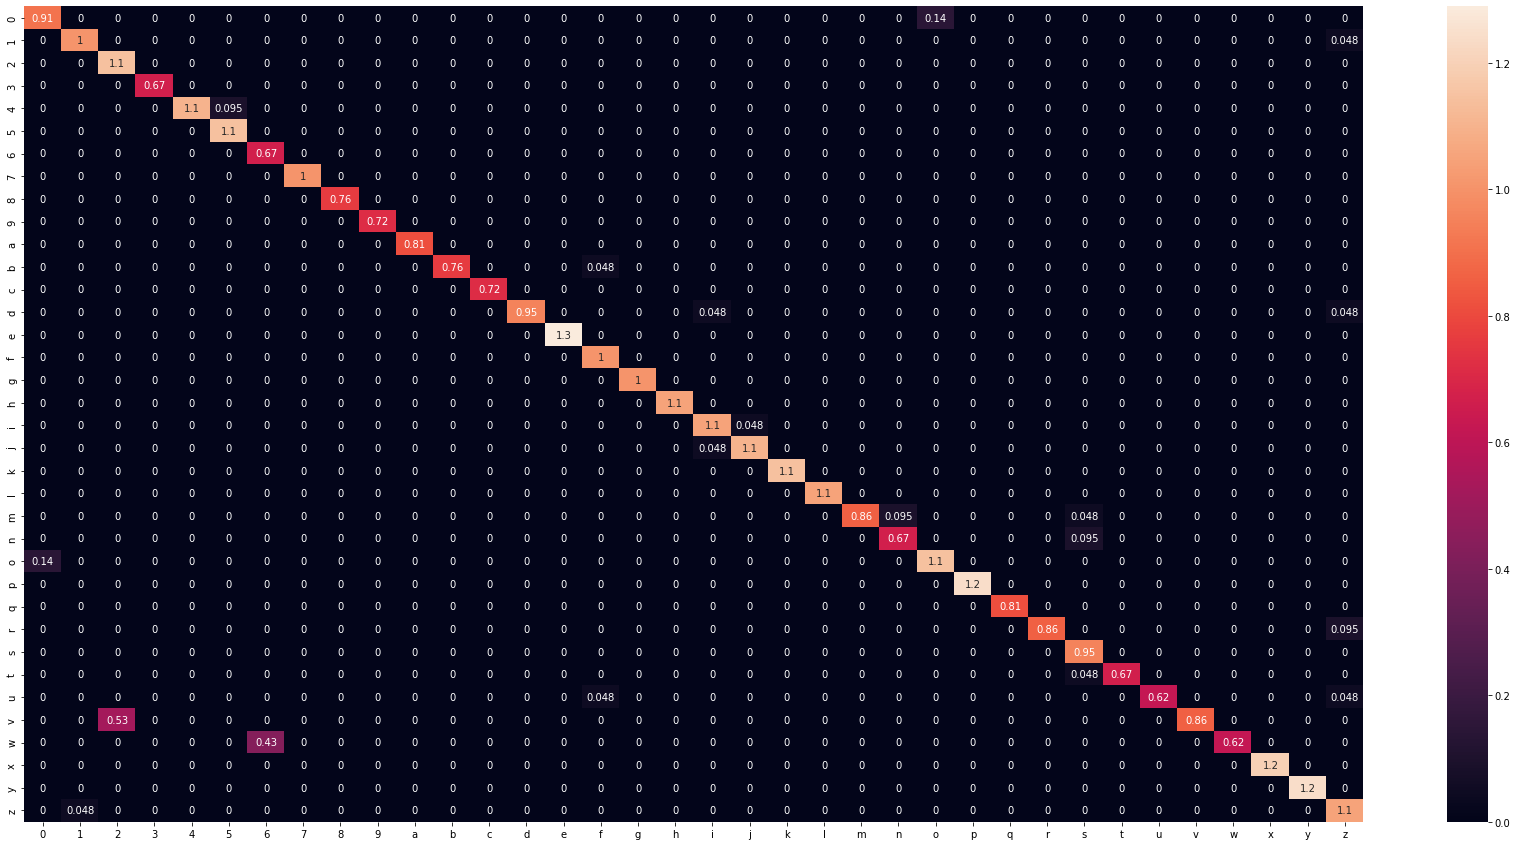

In [ ]:
# calling confusion matrix function to plot the visualisation.
make_confusion_matrix(mnet_y_pred, mnet_y_true)

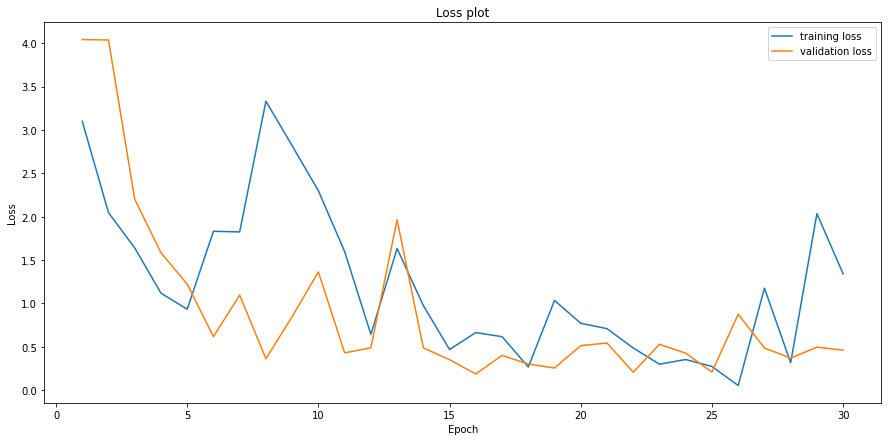

In [ ]:
# plotting both training and validation loss values 

epochs = [i+1 for i in range(num_epochs)]
plt.figure(figsize=(15,7))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.plot(epochs, mnet_training_loss, label = 'training loss')
plt.plot(epochs,mnet_val_loss, label = 'validation loss')
plt.legend()

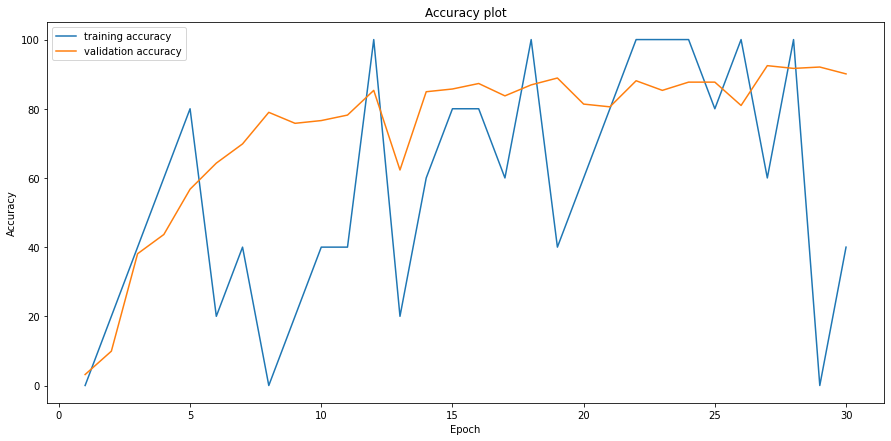

In [ ]:
# plotting both training and validation accuracy values

epochs = [i+1 for i in range(num_epochs)]
plt.figure(figsize=(15,7))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(epochs, mnet_training_accuracies, label = 'training accuracy')
plt.plot(epochs,mnet_val_accuracies, label = 'validation accuracy')
plt.legend()

In [ ]:
# calculating different evaluation metrics like F1 Score, Precision and Recall.
print("F1 SCORE :- ", f1_score(mnet_y_true,mnet_y_pred, average="macro"))
print("PRECISION :-", precision_score(mnet_y_true,mnet_y_pred,average="macro"))
print("RECALL :-", recall_score(mnet_y_true, mnet_y_pred,average="macro"))

F1 SCORE :-  0.941785737632062
PRECISION :- 0.9509930331790236
RECALL :- 0.9442349028213448


In [ ]:
# Generate Features for TSNE and PCA using model and train dataset

def gen_tsne_features(model, dataloader):
    model.eval()
    targets_list = []
    outputs_list = []

    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets_np = targets.data.cpu().numpy()

            outputs = model(inputs)
            outputs_np = outputs.data.cpu().numpy()
            
            targets_list.append(targets_np[:, np.newaxis])
            outputs_list.append(outputs_np)
            
            if ((idx+1) % 10 == 0) or (idx+1 == len(dataloader)):
                print(idx+1, '/', len(dataloader))

    targets = np.concatenate(targets_list, axis=0)
    outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

    return targets, outputs

In [ ]:
# plot the tsne => train and plot both

def tsne_plot(targets, outputs):
    print('generating t-SNE plot...')
    tsne = TSNE(random_state=0)
    tsne_output = tsne.fit_transform(outputs)

    df = pd.DataFrame(tsne_output, columns=['x', 'y'])
    df['targets'] = targets

    plt.rcParams['figure.figsize'] = 15, 15
    sns.scatterplot(
        x='x', y='y',
        cmap=targets,
        hue='targets',
        palette=sns.color_palette("hls", 36),
        data=df,
        marker='o',
        legend="full",
        alpha=0.5
    )

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')

In [ ]:
targets, outputs = gen_tsne_features(mobilenet_model, training_2)

10 / 48
20 / 48
30 / 48
40 / 48
48 / 48


generating t-SNE plot...


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


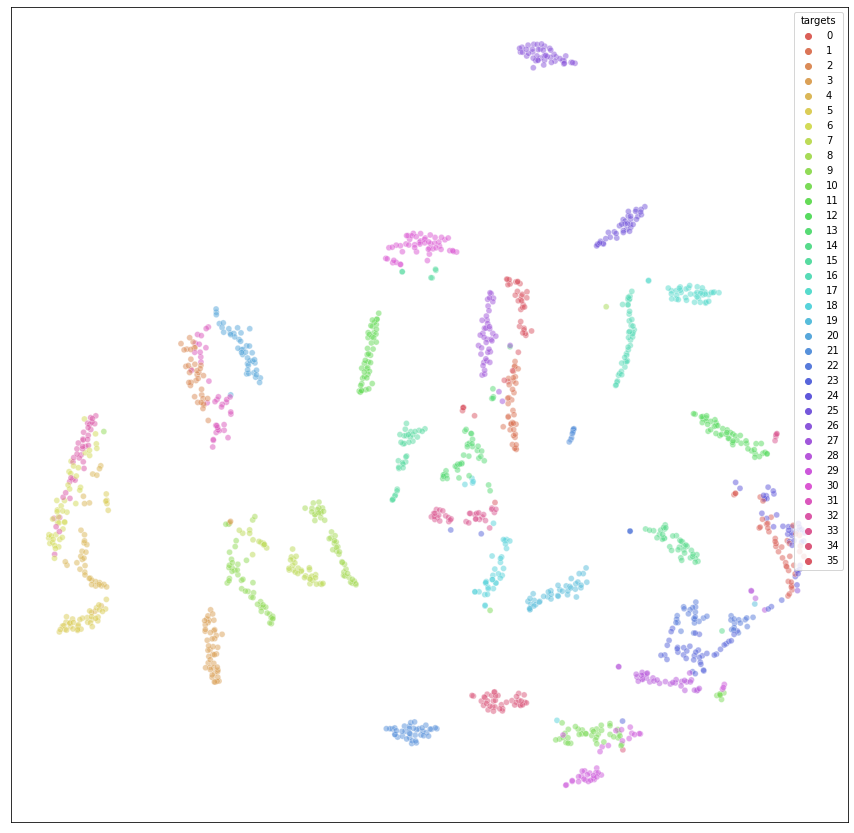

In [ ]:
tsne_plot(targets, outputs)